# Object detection

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

2024-04-10 17:10:03.712689: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 17:10:03.719705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 17:10:03.799000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 17:10:03.799046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 17:10:03.799172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Import data

References:
- Pothole images: https://www.kaggle.com/sachinpatel21/pothole-image-dataset
- Pothole and normal images: https://www.kaggle.com/virenbr11/pothole-and-plain-rode-images
- Bump images: https://data.mendeley.com/datasets/xt5bjdhy5g/1
- Crack images: https://github.com/cuilimeng/CrackForest-dataset

In [2]:
potholes = "obstacle_dataset/potholes"
normal = "obstacle_dataset/normal"
cracks = "obstacle_dataset/cracks"
bumps = "obstacle_dataset/bumps"


In [3]:
batch_size = 4
img_height = 128
img_width = 128

In [4]:
# Function to load images and labels
def load_data(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".JPG"):
            img = load_img(os.path.join(directory, filename), target_size=(img_height, img_width))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

In [5]:
# Load data from directories
potholes_images, potholes_labels = load_data(potholes, "pothole")
normal_images, normal_labels = load_data(normal, "normal")
cracks_images, cracks_labels = load_data(cracks, "crack")
bumps_images, bumps_labels = load_data(bumps, "bump")

In [6]:
# Combine data from all classes
all_images = np.concatenate([potholes_images, normal_images, cracks_images, bumps_images])
all_labels = np.concatenate([potholes_labels, normal_labels, cracks_labels, bumps_labels])

# Convert labels to one-hot encoding
label_to_index = {"pothole": 0, "normal": 1, "crack": 2, "bump": 3}
all_labels_encoded = np.array([label_to_index[label] for label in all_labels])
all_labels_encoded = to_categorical(all_labels_encoded)

## Discover dataset

In [7]:
# print the distribution of the classes
df = pd.DataFrame(all_labels, columns=["label"])
df["label"].value_counts()

label
pothole    20
normal     20
crack      20
bump       20
Name: count, dtype: int64

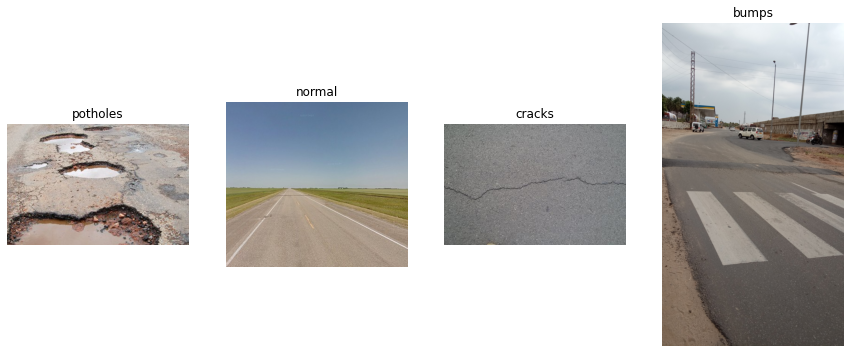

In [24]:
# print one image of each class
fig, axs = plt.subplots(1, 4, figsize=(15, 15))
for i, label in enumerate(["potholes", "normal", "cracks", "bumps"]):
    # images are in the directory 'obstacle_dataset'
    img = mpimg.imread(f"obstacle_dataset/{label}/1.jpg")
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis("off")
plt.show()

## Implement the Convolutional Neural Network (CNN) method

In [8]:
nb_classes = df["label"].nunique()

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels_encoded, test_size=0.2, random_state=42, stratify=all_labels_encoded)

In [10]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, subset='training')
validation_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation')

In [12]:
# create the model : CNN
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(nb_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# save the model
model.save('obstacle_detection_model.h5')

Epoch 1/50


13/13 [==============================] - 2s 71ms/step - loss: 1.5011 - accuracy: 0.3077 - val_loss: 1.3778 - val_accuracy: 0.1667
Epoch 2/50
13/13 [==============================] - 1s 53ms/step - loss: 1.3307 - accuracy: 0.2885 - val_loss: 1.2639 - val_accuracy: 0.4167
Epoch 3/50
13/13 [==============================] - 1s 52ms/step - loss: 1.2753 - accuracy: 0.4038 - val_loss: 1.1495 - val_accuracy: 0.4167
Epoch 4/50
13/13 [==============================] - 1s 50ms/step - loss: 1.0253 - accuracy: 0.5385 - val_loss: 1.0770 - val_accuracy: 0.3333
Epoch 5/50
13/13 [==============================] - 1s 51ms/step - loss: 0.8256 - accuracy: 0.6154 - val_loss: 1.3129 - val_accuracy: 0.2500
Epoch 6/50
13/13 [==============================] - 1s 62ms/step - loss: 0.8648 - accuracy: 0.5192 - val_loss: 0.9826 - val_accuracy: 0.3333
Epoch 7/50
13/13 [==============================] - 1s 50ms/step - loss: 0.7855 - accuracy: 0.6731 - val_loss: 0.9471 - val_accuracy: 0.4167
Epoch 8/50
13/13 [======

/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


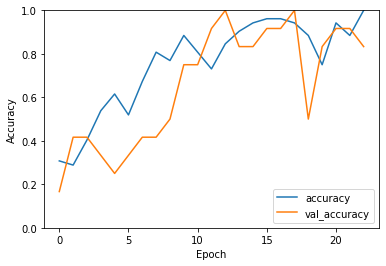

In [13]:
# plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.show()

## Evaluate the performance of the method

In [14]:
# predict the class on test images
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

1/1 [==============================] - 0s 181ms/step


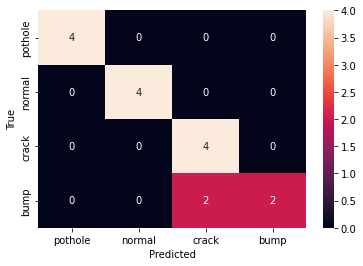

In [15]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# display confusion matrix with labels
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# compute accuracy, precision, recall and f1-score
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=label_to_index.keys()))

              precision    recall  f1-score   support

     pothole       1.00      1.00      1.00         4
      normal       1.00      1.00      1.00         4
       crack       0.67      1.00      0.80         4
        bump       1.00      0.50      0.67         4

    accuracy                           0.88        16
   macro avg       0.92      0.88      0.87        16
weighted avg       0.92      0.88      0.87        16

